<a href="https://colab.research.google.com/github/ulanserikuly/Algorithms-for-massive-data-project/blob/main/Face_comic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Algorithms for Massive Data

---

# Face/comic recognizer with deep learning

Project for the module Algoritms for Massive Data of the course Algoritms for Massive Data, Cloud and Distributed Computing for the academic year 2021-2022. The task is to implement a deep-learning-based system discriminating between real faces and comics, using the «Comics faces» dataset. The «Comic faces» dataset is published on Kaggle and released under the CC-BY 4.0 license, with attribution required.

If you want to have a look before starting:

Dataset link: https://www.kaggle.com/defileroff/comic-faces-paired-synthetic-v2


# Importing kaggle.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ulanserikuly","key":"9e2c8c2e08ddb7d26724fb5419b3ad9e"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

*Importing Comic Face Paired Synthetic Dataset.*

In [ ]:
! kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2

comic-faces-paired-synthetic-v2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip comic-faces-paired-synthetic-v2.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5503.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5504.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5505.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5506.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5507.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5508.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5509.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/551.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5510.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5511.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/face

In [ ]:
!rm -rf face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples
!ls face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/

comics	faces


In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import random
import pickle
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import time
import sklearn
import seaborn as sn
import keras_tuner
from keras_tuner.tuners import RandomSearch, Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters

DATADIR = "/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela"
CATEGORIES = ["comics", "faces"]

In [ ]:
path_faces = os.path.join(DATADIR, CATEGORIES[1])   # path to the faces folder
path_comics = os.path.join(DATADIR, CATEGORIES[0])  # path to the comics folder

# just to show the path to the 2 folders in which we have the images, without the part before
print(path_faces[-62:])
print(path_comics[-63:])

/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces
/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics


In [ ]:
# just show the first 5 images in the folder of real faces
os.listdir(path_faces)[:5]

['866.jpg', '9549.jpg', '239.jpg', '6554.jpg', '2320.jpg']

In [ ]:
# just show the first 5 images in the folder of comics faces
os.listdir(path_comics)[:5]

['866.jpg', '9549.jpg', '239.jpg', '6554.jpg', '2320.jpg']

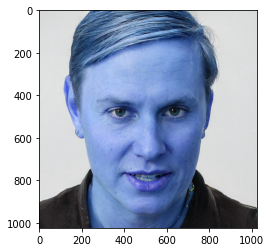

In [ ]:
# Just show one image of a real face - the 100-th one in the folder
image_array = cv2.imread(os.path.join(path_faces, os.listdir(path_faces)[100]))
plt.imshow(image_array)
plt.show()

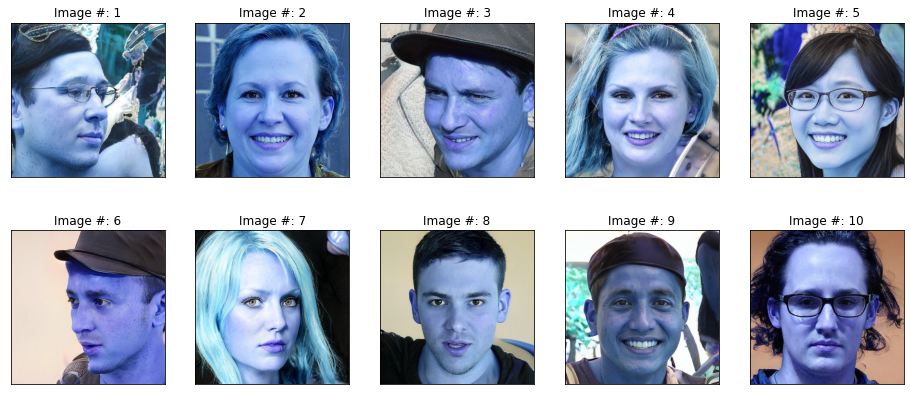

In [ ]:
# plot the first 10 images
plt.figure(figsize=(16,7))
for image_number in range(0,10):
    plt.subplot(2,5,image_number+1)
    image_array = cv2.imread(os.path.join(path_faces, os.listdir(path_faces)[image_number]))
    plt.imshow(image_array)
    plt.xticks([])
    plt.yticks([])
    plt.title("Image #: " + str(image_number+1))

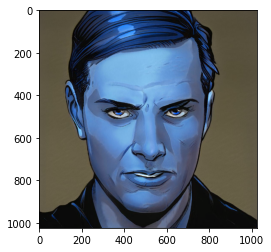

In [ ]:
# Just show one image of a comics' face - the 100-th one in the folder
image_array = cv2.imread(os.path.join(path_comics, os.listdir(path_comics)[100]))
plt.imshow(image_array)
plt.show()

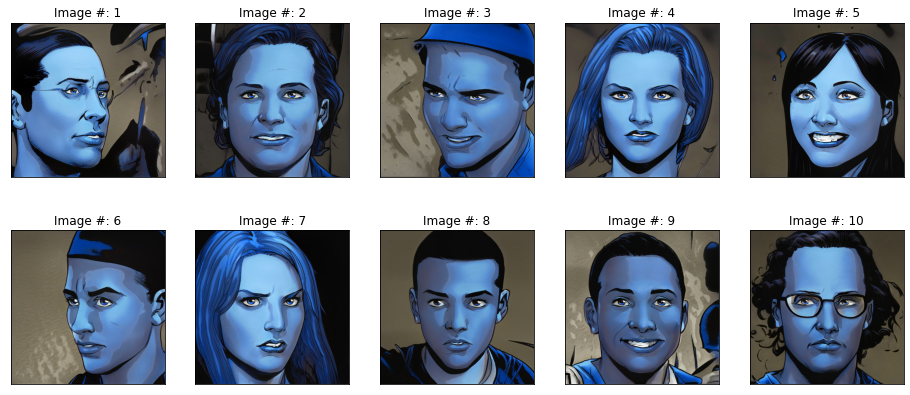

In [ ]:
# plot the first 10 images
plt.figure(figsize=(16,7))
for image_number in range(0,10):
    plt.subplot(2,5,image_number+1)
    image_array = cv2.imread(os.path.join(path_comics, os.listdir(path_comics)[image_number]))
    plt.imshow(image_array)
    plt.xticks([])
    plt.yticks([])
    plt.title("Image #: " + str(image_number+1))

In [ ]:
image_array.shape

(1024, 1024, 3)

In [ ]:
#At this stage we are ready to create a list that contains the images and their labels 
#starting from an empty list
#partiamo da una lista vuota e poi facciamo append 
images = []
image_size = 128

In [ ]:
#the for cycle just created above is insterted into a function that create the dataset 
def dataset():
    for categories in CATEGORIES: 
        path = os.path.join(DATADIR, categories)
        label_class = CATEGORIES.index(categories)
        for pic in os.listdir(path):
            array_pic = cv2.imread(os.path.join(path, pic),0)
            array_pic = cv2.resize(array_pic,(image_size , image_size ),0) #make the image size 70*70
            images.append([array_pic,label_class])
    

In [ ]:
dataset()

In [ ]:
print(len(images))

20000


In [ ]:
import random
# SHUFFLING the data
random.shuffle(images)
# Check the shuffling
for sample in images[:10]:
    print(sample[1])

1
1
1
0
1
1
1
1
0
1


# Train / Test split and model


In [ ]:
# Next, we separate images from labels
X = [] #Initialize empty list for images
y = [] #Initialize empty list for labels

# Fill the lists
for features,label in images:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, 128, 128, 1)) #Using a grescale I have to set 1 channel

X = np.array(X).reshape(-1, 128, 128, 1) 
y = np.array(y)

[[[[ 36]
   [ 39]
   [ 41]
   ...
   [ 11]
   [ 12]
   [ 15]]

  [[ 29]
   [ 34]
   [ 37]
   ...
   [  8]
   [  9]
   [  9]]

  [[ 25]
   [ 31]
   [ 38]
   ...
   [  7]
   [  8]
   [  8]]

  ...

  [[248]
   [247]
   [248]
   ...
   [ 90]
   [113]
   [106]]

  [[247]
   [248]
   [250]
   ...
   [ 77]
   [113]
   [107]]

  [[247]
   [249]
   [249]
   ...
   [ 97]
   [101]
   [140]]]]


In [ ]:

#Normalization of pixels values
x = X/255.0 
     

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
# Check the lengths
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

16000
16000
4000
4000


#One Hot Encoding

In [ ]:
# Equivalent to One-Hot-Encoding
y_train = keras.utils.np_utils.to_categorical(y_train, 2)
y_test = keras.utils.np_utils.to_categorical(y_test, 2)

In [ ]:
y_train.shape, y_test.shape

((16000, 2, 2), (4000, 2, 2))

#First hyperparameters tuning

In [ ]:
# I consider a subset of 4000 elements from the original training set due to execution time and computational resources limitations.
x_train_sub1, x_train_not1, y_train_sub1, y_train_not1 = train_test_split(x_train,y_train,test_size=0.75)
print(len(x_train_sub1)) #4000 elements
print(len(y_train_sub1)) #4000 elements

4000
4000


In [ ]:
dense_layers = [1]
layer_sizes = [32, 64, 128]
conv_layers = [2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=x_train_sub1.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(2))
            model.add(Activation('relu'))

            tensorboard = TensorBoard(log_dir="logs_opt_2r/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(x_train_sub1, y_train_sub1,
                      batch_size=32,
                      epochs=5,
                      validation_split=0.2,
                      callbacks=[tensorboard]
                      )

2-conv-32-nodes-1-dense-1671132693
Epoch 1/5
100/100 [==============================] - 62s 606ms/step - loss: 7.4536 - accuracy: 0.5128 - val_loss: 7.8411 - val_accuracy: 0.4888
Epoch 2/5
100/100 [==============================] - 55s 549ms/step - loss: 7.4720 - accuracy: 0.5128 - val_loss: 7.8411 - val_accuracy: 0.4888
Epoch 3/5
100/100 [==============================] - 63s 630ms/step - loss: 7.4720 - accuracy: 0.5128 - val_loss: 7.8411 - val_accuracy: 0.4888
Epoch 4/5
100/100 [==============================] - 58s 579ms/step - loss: 7.4720 - accuracy: 0.5128 - val_loss: 7.8411 - val_accuracy: 0.4888
Epoch 5/5
100/100 [==============================] - 64s 642ms/step - loss: 7.4720 - accuracy: 0.5128 - val_loss: 7.8411 - val_accuracy: 0.4888
3-conv-32-nodes-1-dense-1671133017
Epoch 1/5
100/100 [==============================] - 66s 652ms/step - loss: 0.9114 - accuracy: 0.7400 - val_loss: 0.1602 - val_accuracy: 0.9762
Epoch 2/5
100/100 [==============================] - 67s 666ms/ste

#Best model selection: second hyperparameters tuning

In [ ]:
from sklearn.model_selection import train_test_split

In [58]:
# now split data and lock somewhere your test data
# we are going to use only training data, and just a portion of them as validation for the hyperparameter tuning
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [59]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  stratify=y_train)

In [60]:
print("Train examples", x_train.shape)
print("Validation examples", x_val.shape)
print("Test examples", x_test.shape)

Train examples (14400, 128, 128, 1)
Validation examples (1600, 128, 128, 1)
Test examples (4000, 128, 128, 1)


In [61]:
np.unique(y_test, return_counts=True)


(array([0, 1]), array([2000, 2000]))

In [62]:
y_train.shape, y_val.shape, y_test.shape

((14400,), (1600,), (4000,))

In [63]:
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)

x_train shape: (14400, 128, 128, 1)
x_val shape: (1600, 128, 128, 1)
x_test shape: (4000, 128, 128, 1)


In [64]:
#hp.Choice('filters_1', values=[100, 200])

def build_model(hp):
    model = tf.keras.Sequential(
    [
        keras.Input(shape=x_train.shape[1:]),
        #convolutional layer
        keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), activation="relu"),
        #pooling layer
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #another convolutional layer
        keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), activation="relu"),
        #another pooling layer
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
     
        #another convolutional layer
        keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), activation="relu"),
        #another pooling layer
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        #flatten layer
        keras.layers.Flatten(),
        #dropout layer
        keras.layers.Dropout(hp.Choice('dropout_rate', values=[0.5, 0.7])),
        #last 2 neurons for the outcome
        keras.layers.Dense(2, activation="softmax")
    ])

    #compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', values=[1e-2, 1e-3])),
                  metrics=['accuracy'])
    return model

In [65]:

tuner = Hyperband(build_model, 
                  objective='val_accuracy', 
                  max_epochs=10,
                  hyperband_iterations=1,
                  directory=DATADIR,
                  project_name='deep-learning-experiment_2')

In [66]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

In [ ]:
# I tune the hyperparameters over the model. The number of trials is 4, coming from 2 values for 2 hyperparameters studied.
tuner.search(x=x_train, y=y_train, epochs=10, batch_size=200, use_multiprocessing=True, validation_data=(x_val, y_val), callbacks=[early_stop]) 
     

Trial 4 Complete [00h 08m 24s]
val_accuracy: 0.9962499737739563

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 34m 14s


In [ ]:
#I get the best hyperparameters from the tuner 
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Hyperparameter for Dropout rate:", best_hps.get('dropout_rate'))
print("Hyperparameter for learning rate:", best_hps.get('lr'))

Hyperparameter for Dropout rate: 0.5
Hyperparameter for learning rate: 0.001


In [ ]:
#Here I define the model over the best hyperparameters
model = tuner.hypermodel.build(best_hps)
     

In [ ]:
#Here I fit the model over a random number of 10 epochs
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
450/450 [==============================] - 268s 594ms/step - loss: 0.0522 - accuracy: 0.9779 - val_loss: 0.0108 - val_accuracy: 0.9950
Epoch 2/10
450/450 [==============================] - 265s 589ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 7.0853e-04 - val_accuracy: 1.0000
Epoch 3/10
450/450 [==============================] - 263s 584ms/step - loss: 0.0032 - accuracy: 0.9986 - val_loss: 6.7891e-04 - val_accuracy: 1.0000
Epoch 4/10
450/450 [==============================] - 262s 582ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 6.5403e-04 - val_accuracy: 1.0000
Epoch 5/10
450/450 [==============================] - 261s 580ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 3.6592e-04 - val_accuracy: 1.0000
Epoch 6/10
450/450 [==============================] - 259s 575ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0016 - val_accuracy: 0.9994
Epoch 7/10
450/450 [==============================] - 258s 574ms/step - loss: 0.0022 - accuracy: 0.9994 - va

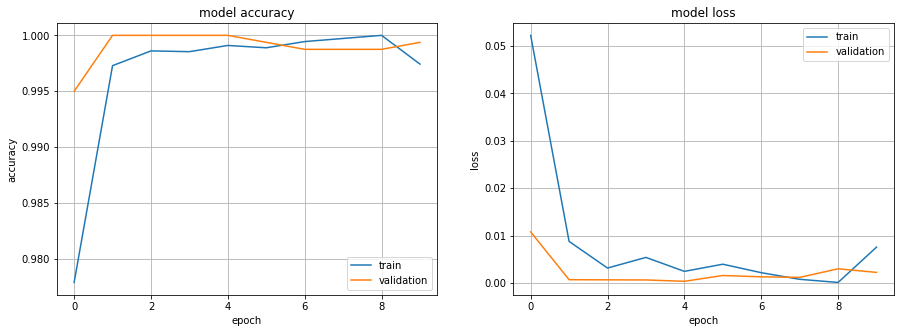

In [ ]:
# Setting the plot for the accuracy
plt.figure(1, figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid()

# Setting the plot for the loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
val_acc_per_epoch = history.history['val_accuracy']
best_number_of_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch))
print('Best epoch: %d' % (best_number_of_epoch,))

Best epoch: 1


In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

In [ ]:
# re-train the model
hypermodel.fit(x_train, y_train, epochs=best_number_of_epoch, validation_data=(x_val, y_val))

450/450 [==============================] - 268s 595ms/step - loss: 0.0531 - accuracy: 0.9793 - val_loss: 0.0023 - val_accuracy: 0.9994


In [ ]:
# Evaluatation of the final model on the the test set
score = hypermodel.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0062363650649785995
Test accuracy: 0.9982500076293945


**Predict on new data**

188416/179976 [===============================] - 0s 1us/step


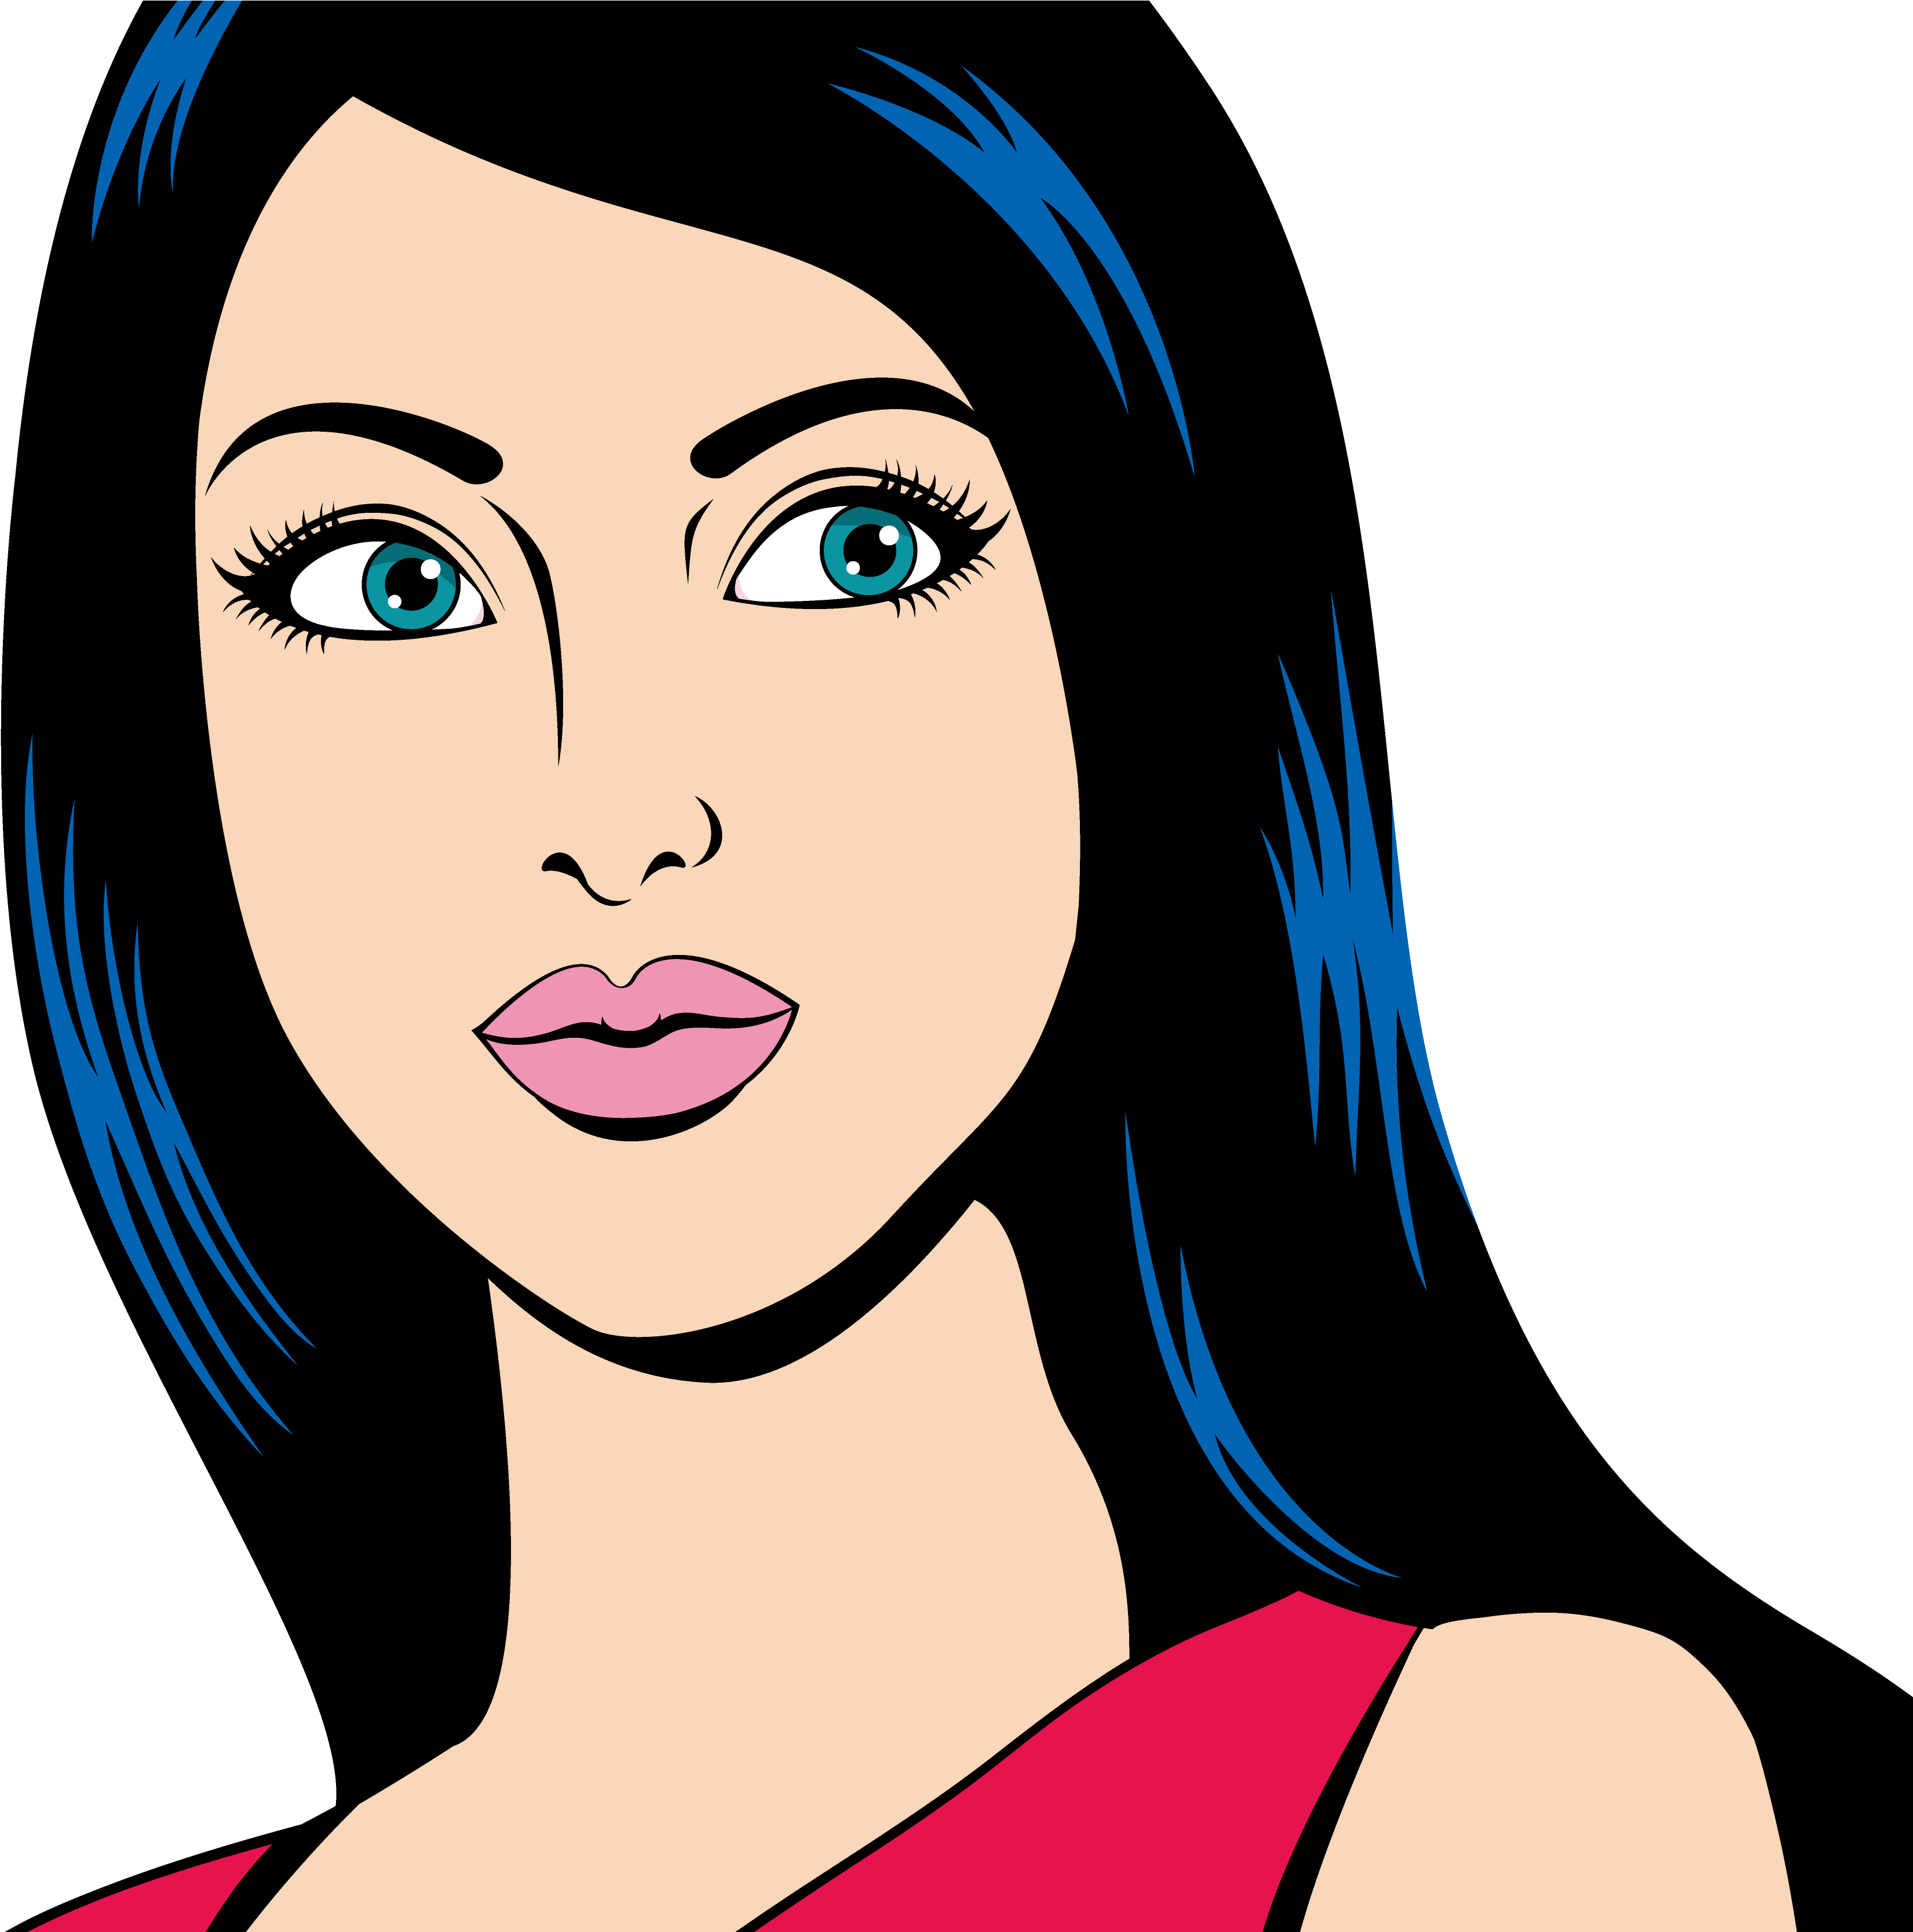

In [ ]:
comic_url = "https://www.seekpng.com/png/full/156-1565591_pop-art-comics-female-comic-book-female-comic.png"
comic_path = tf.keras.utils.get_file('156-1565591_pop-art-comics-female-comic-book-female-comic', origin=comic_url)

import IPython
IPython.display.Image(comic_url, width = 250)

In [ ]:
img = tf.keras.utils.load_img(
    comic_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to comics with a 100.00 percent confidence.


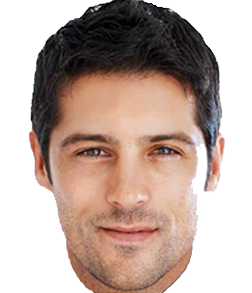

In [ ]:
face_url = "http://pngimg.com/uploads/face/face_PNG11761.png"
face_path = tf.keras.utils.get_file('12', origin=face_url)

import IPython
IPython.display.Image(face_url, width = 250)

In [ ]:
img1 = tf.keras.utils.load_img(
    face_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img1)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to comics with a 63.07 percent confidence.
